# Classificação de categoria de jogos da Steam
## Projeto da disciplina SCC0230 - Inteligência Artificial

## Membros

* Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

* Arthur Santorum Lorenzetto - arts.lorenzetto@usp.br - 12559465

* Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490 (Vice-Líder)

* Gustavo Silva de Oliveira - gustavo.oliveira03@usp.br - 12567231 

* Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472 

* Pedro Henrique de Freitas Maçonetto - pedromaconetto@usp.br - 12675419 (Líder)

* Vitor Okubo Ianella - vitorok.03@gmail.com - 12559451


# Desenvolvimento

In [1]:
# Importando Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [2]:
# Carregando Dados da Steam
df = pd.read_csv('steam_metadados.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


---
## Tratamento dos Dados

In [3]:
# Removendo colunas inúteis
df.drop(columns=['appid', 'steamspy_tags', 'platforms', 'developer', 'publisher', 'achievements'], inplace=True)

# Removendo NaN
df.dropna(inplace=True)

In [4]:
# Classificando apenas pelo gênero principal (primeiro)
df['main_genre'] = df['genres'].apply(lambda x: str(x).split(';')[0])
df.main_genre

0           Action
1           Action
2           Action
3           Action
4           Action
           ...    
27070    Adventure
27071       Action
27072       Action
27073    Adventure
27074    Adventure
Name: main_genre, Length: 27075, dtype: object

In [5]:
# Total de avaliações de um jogo
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings'] 
df.total_ratings

0        127873
1          3951
2          3814
3          1540
4          5538
          ...  
27070         3
27071         9
27072         1
27073         2
27074         4
Name: total_ratings, Length: 27075, dtype: int64

In [6]:
# Reestruturando valores de idade mínima
def age_transform(age):
  age = int(age)
  if age == 3 or age == 7:
    return 0
  else:
    return age
  
df['required_age'] = df['required_age'].apply(age_transform)
df.required_age

0        0
1        0
2        0
3        0
4        0
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: required_age, Length: 27075, dtype: int64

In [7]:
# Jogo Singleplayer ou Multiplayer
def multi_or_single(category):
  category = str(category).split(';')
  if 'Multi-player' in category:
    return 1 # Multiplayer
  else:
    return 0 # Singleplayer

df['is_multiplayer'] = df['categories'].apply(multi_or_single)
del df['categories']

In [8]:
# Estimativa do número de compradores
def mean_owners(text):
    txt_min, txt_max = text.split('-')
    return (int(txt_max) + int(txt_min)) / 2
    
df['owners'] =  df['owners'].apply(mean_owners)

In [9]:
# Coletando Ano de lançamento do jogo 
df['year_release'] = df['release_date'].apply(lambda x: str(x).split('-')[0])
df.year_release

0        2000
1        1999
2        2003
3        2001
4        1999
         ... 
27070    2019
27071    2019
27072    2019
27073    2019
27074    2019
Name: year_release, Length: 27075, dtype: object

In [17]:
# Dicotomizando jogos em Ação ou Não-Ação
df['is_action'] = np.where(df['main_genre'] == "Action", 1, 0)
df.is_action

0        1
1        1
2        1
3        1
4        1
        ..
27070    0
27071    1
27072    1
27073    0
27074    0
Name: is_action, Length: 27075, dtype: int32

In [11]:
# Dados tratados
df.head()

,name,release_date,english,required_age,genres,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,main_genre,total_ratings,is_multiplayer,year_release,is_action
0,Counter-Strike,2000-11-01,1,0,Action,124534,3339,17612,317,15000000.0,7.19,Action,127873,1,2000,1
1,Team Fortress Classic,1999-04-01,1,0,Action,3318,633,277,62,7500000.0,3.99,Action,3951,1,1999,1
2,Day of Defeat,2003-05-01,1,0,Action,3416,398,187,34,7500000.0,3.99,Action,3814,1,2003,1
3,Deathmatch Classic,2001-06-01,1,0,Action,1273,267,258,184,7500000.0,3.99,Action,1540,1,2001,1
4,Half-Life: Opposing Force,1999-11-01,1,0,Action,5250,288,624,415,7500000.0,3.99,Action,5538,1,1999,1


## Verificando Correlação dos Atributos

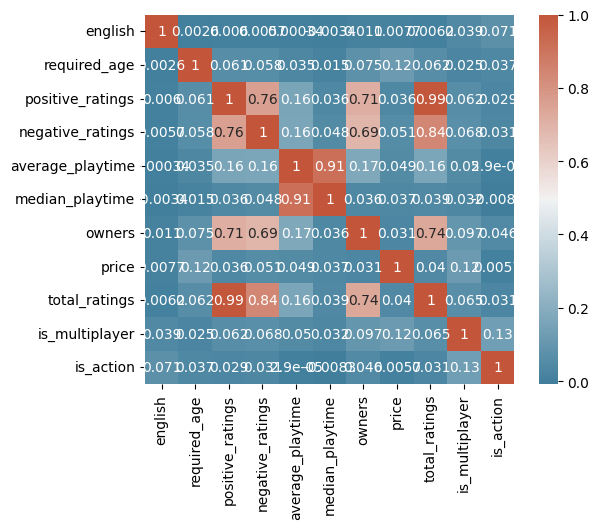

In [18]:
correlation = df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(
    correlation, 
    cmap=cmap,
    square=True, 
    annot = True
)

# Aplicando Modelos de Classificação

## k-Nearest Neighbor (KNN)

In [19]:
Y = df['is_action']
X = df[['english', 'is_multiplayer', 'total_ratings', 'owners', 'price', 'median_playtime', 'year_release']]

In [20]:
# Separando em conjunto de treinamento e teste (Hold-Out)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [21]:
# Escolhendo melhor número de vizinhos k
scores = []

range_k = range(1, 30)

for i in range_k:
  neighbor = KNeighborsClassifier(n_neighbors=i, p=2)
  neighbor.fit(X_train, Y_train)

  score = neighbor.score(X_test, Y_test, sample_weight=None)
  scores.append(score)

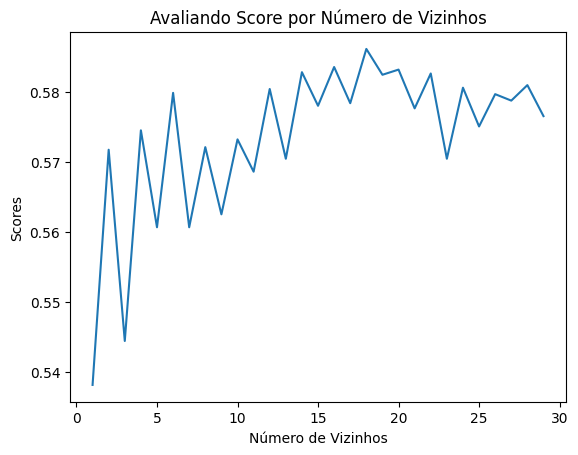

In [22]:
# Plotando Score por Número de vizinhos
plt.plot(range_k, scores)

plt.xlabel("Número de Vizinhos")
plt.ylabel("Scores")
plt.title("Avaliando Score por Número de Vizinhos")

plt.show()

In [34]:
best_score = max(scores)
print(f"O Score do melhor modelo foi {best_score}")

O Score do melhor modelo foi 0.5861495844875346


In [38]:
# Escolhendo o k com maior Score
best_k = range_k[scores.index(best_score)]
print(f"O melhor número de vizinhos k foi {best_k}.")

O melhor número de vizinhos k foi 18.


In [39]:
# Ajustando modelo KNN com k=18
knn_model = KNeighborsClassifier(n_neighbors=best_k, p=2)

# Treinando com conjunto de treinamento
knn_model.fit(X_train, Y_train)

# Predizendo para o conjunto de teste
results = knn_model.predict(X_test)
results

array([0, 0, 0, ..., 0, 0, 0])

### Medidas de Avaliação do KNN

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [48]:
# Matriz de Confusão
conf_matrix = confusion_matrix(Y_test, results)
print("True Positive: ", conf_matrix[0, 0])
print("False Positive: ", conf_matrix[1, 0])
print("True Negative: ", conf_matrix[0, 1])
print("False Negative: ", conf_matrix[1, 1])

print(conf_matrix)

True Positive:  2707
False Positive:  1775
True Negative:  466
False Negative:  467
[[2707  466]
 [1775  467]]


In [43]:
# Métrica de Revocação
recall_score(Y_test, results)

0.20829616413916147

In [42]:
# Métrica de Precisão
precision_score(Y_test, results)

0.5005359056806002

---
## Classificação por Árvore de Decisão

In [50]:
# Modelo Decision Tree
clf = tree.DecisionTreeClassifier()

# Treinando com conjunto de treinamento
clf.fit(X_train, Y_train)

# Predizendo com conjunto de teste
results = clf.predict(X_test)

# Avaliando Score do Modelo
clf.score(X_test, Y_test, sample_weight=None)

0.561034164358264

### Medidas de avaliação do modelo:

In [52]:
# Matriz de Confusão
conf_matrix = confusion_matrix(Y_test,results)
print("True Positive: ", conf_matrix[0, 0])
print("False Positive: ", conf_matrix[1, 0])
print("True Negative: ", conf_matrix[0, 1])
print("False Negative: ", conf_matrix[1, 1])

conf_matrix

True Positive:  2170
False Positive:  1374
True Negative:  1003
False Negative:  868


array([[2170, 1003],
       [1374,  868]], dtype=int64)

In [53]:
# Métrica de Revocação
recall_score(Y_test,results)

0.3871543264942016

In [54]:
# Métrica de Precisão
precision_score(Y_test,results)

0.46392303580972744

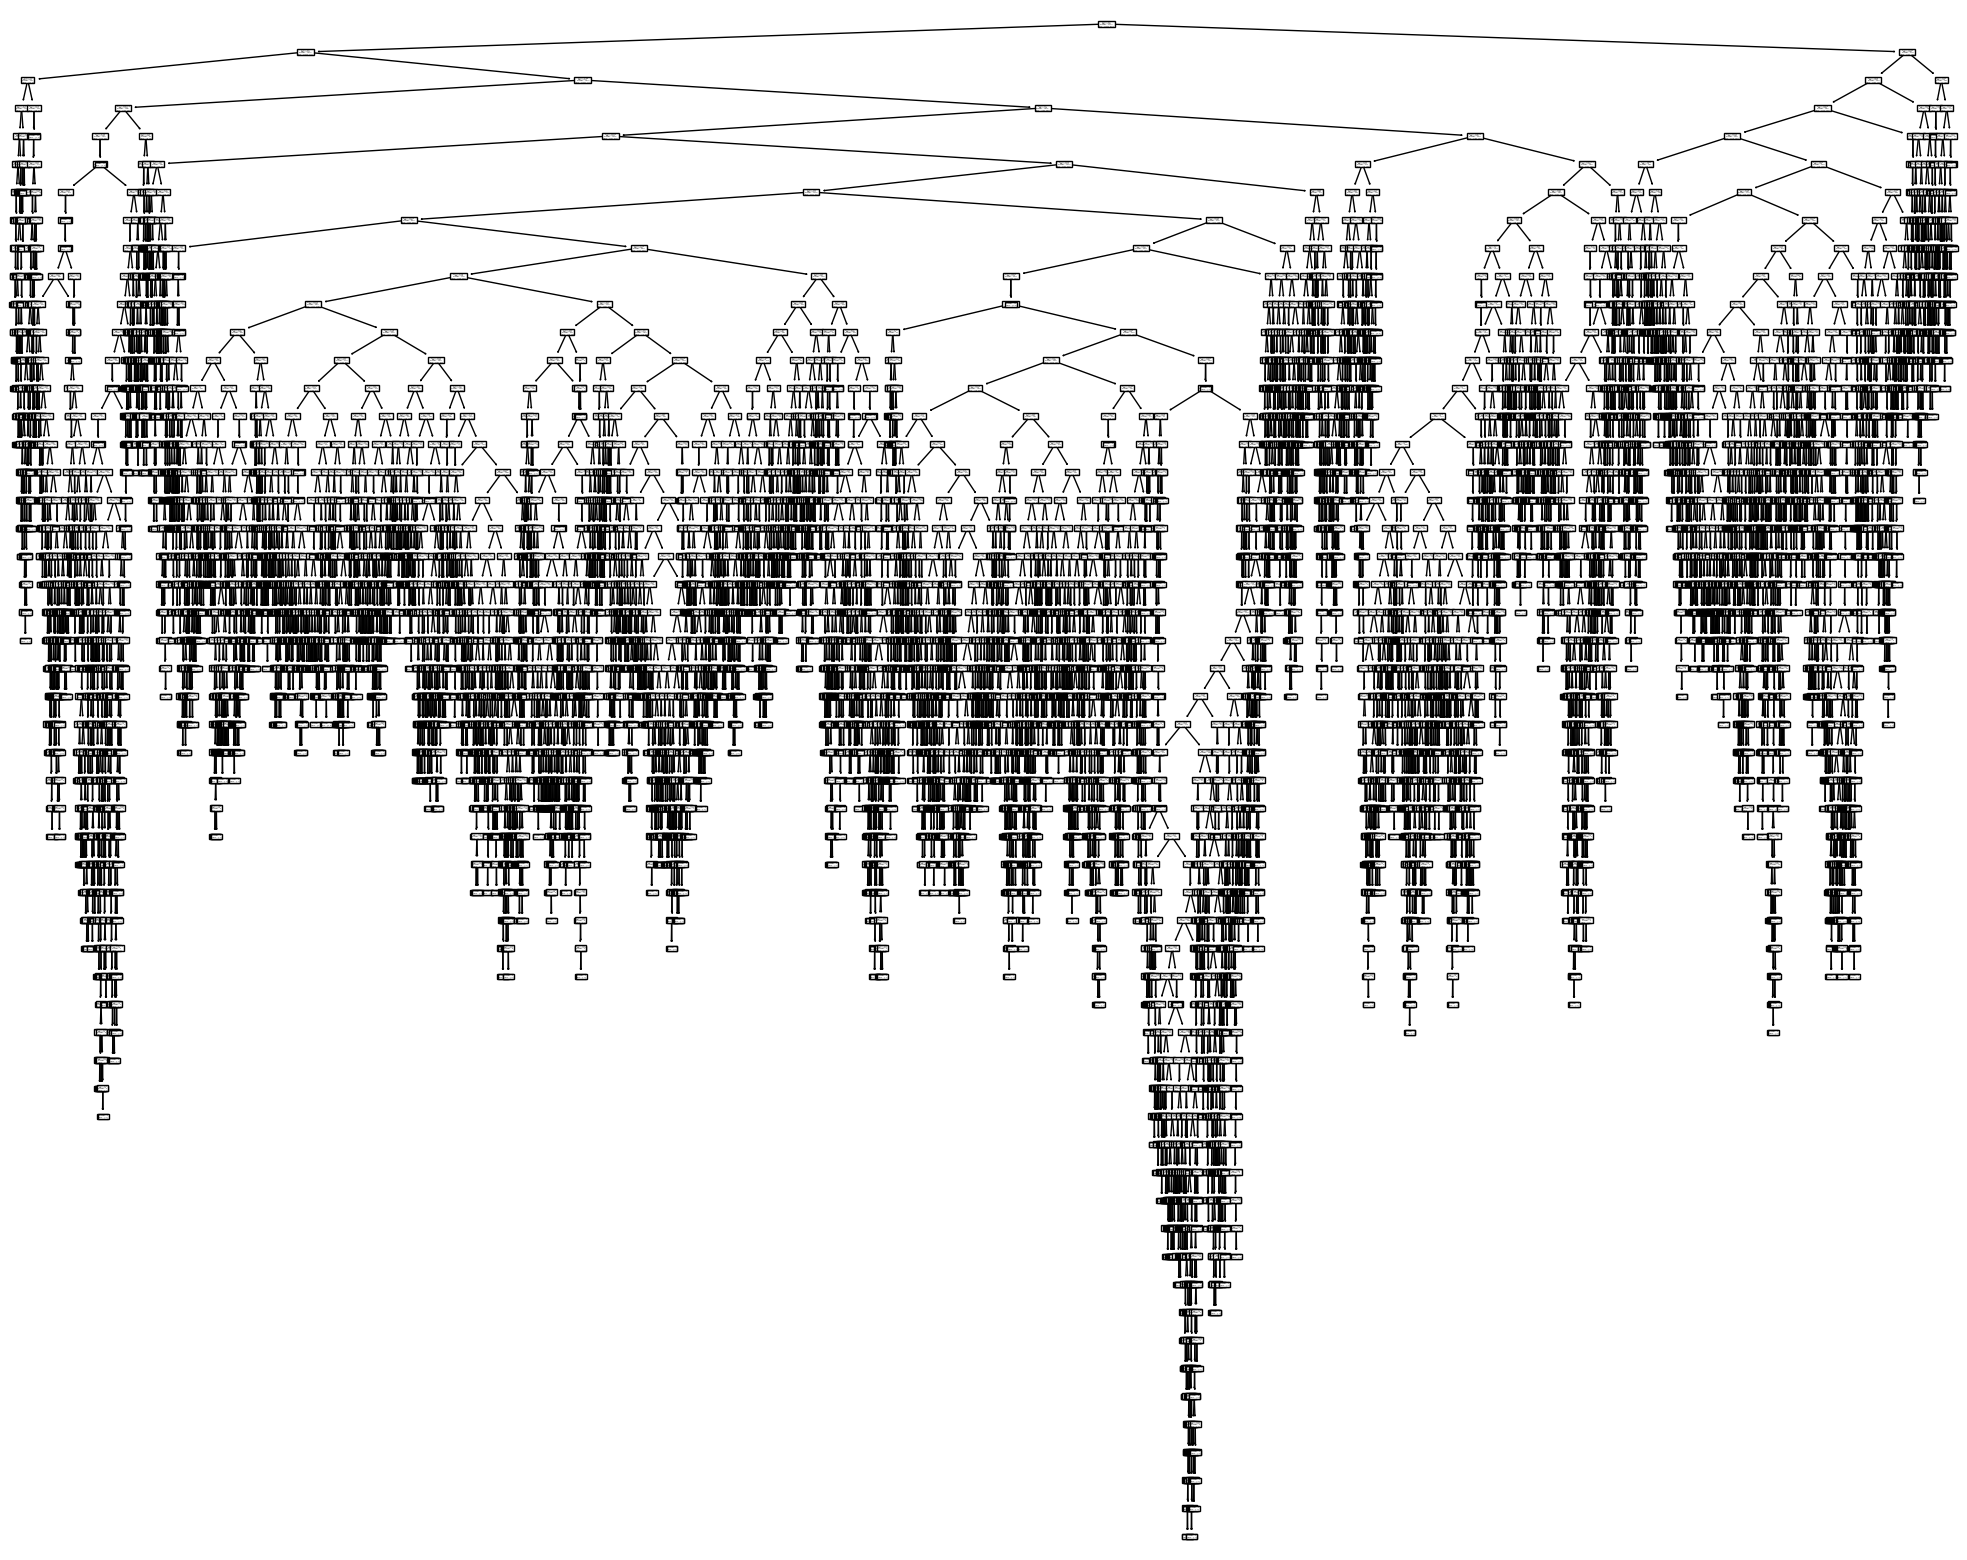

In [51]:
fig = plt.figure(figsize=(25, 20))

_ = tree.plot_tree(clf)